# Performance Baseline Monitoring Dashboard

This notebook provides comprehensive diagnostics to monitor quActuary system performance, track optimization effectiveness, and detect performance regressions.

## Key Metrics Tracked:
- Execution time across different portfolio sizes
- Memory usage and efficiency
- Optimization speedup ratios
- Numerical accuracy validation
- Resource utilization patterns

## 1. Setup and Imports

In [1]:
import os
import sys
import time
import json
import psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, timedelta
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Add parent directory to path
sys.path.append(os.path.abspath('../'))

import quactuary as qa
import quactuary.book as book
from quactuary.backend import set_backend
from quactuary.book import LOB, PolicyTerms, Inforce, Portfolio
from quactuary.distributions.frequency import Poisson, NegativeBinomial, Geometric
from quactuary.distributions.severity import Lognormal, Pareto, Exponential, Gamma
from quactuary.pricing import PricingModel

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

## 2. Performance Monitoring Classes

In [2]:
class PerformanceMonitor:
    """Comprehensive performance monitoring for quActuary operations."""
    
    def __init__(self):
        self.process = psutil.Process()
        self.results = []
        self.baseline_file = "performance_baseline.json"
        
    def measure_execution(self, func, *args, **kwargs):
        """Measure execution time and resource usage."""
        # Pre-execution metrics
        start_time = time.time()
        start_memory = self.process.memory_info().rss / (1024 * 1024)  # MB
        
        # Execute function
        result = func(*args, **kwargs)
        
        # Post-execution metrics
        end_time = time.time()
        end_memory = self.process.memory_info().rss / (1024 * 1024)  # MB
        
        execution_time = end_time - start_time
        memory_delta = end_memory - start_memory
        
        return {
            'result': result,
            'execution_time': execution_time,
            'memory_delta': memory_delta,
            'peak_memory': end_memory
        }
    
    def run_benchmark(self, portfolio_sizes, n_simulations, optimization_configs):
        """Run comprehensive benchmark across different configurations."""
        results = []
        
        for size in portfolio_sizes:
            portfolio = self.create_test_portfolio(size)
            
            for n_sims in n_simulations:
                for config_name, config in optimization_configs.items():
                    print(f"Running: {size} portfolio, {n_sims} sims, {config_name}")
                    
                    set_backend("classical")
                    pm = PricingModel(portfolio)
                    
                    # Build simulation kwargs
                    sim_kwargs = {
                        'n_sims': n_sims,
                        'tail_alpha': 0.05
                    }
                    sim_kwargs.update(config)
                    
                    # Measure performance
                    metrics = self.measure_execution(pm.simulate, **sim_kwargs)
                    
                    results.append({
                        'timestamp': datetime.now().isoformat(),
                        'portfolio_size': size,
                        'n_simulations': n_sims,
                        'optimization': config_name,
                        'execution_time': metrics['execution_time'],
                        'memory_delta': metrics['memory_delta'],
                        'peak_memory': metrics['peak_memory'],
                        'mean_estimate': metrics['result'].estimates['mean'],
                        'var_estimate': metrics['result'].estimates['VaR']
                    })
        
        self.results = results
        return pd.DataFrame(results)
    
    def create_test_portfolio(self, size):
        """Create standardized test portfolio."""
        policy_terms = PolicyTerms(
            effective_date=date(2026, 1, 1),
            expiration_date=date(2027, 1, 1),
            lob=LOB.GLPL,
            exposure_base=book.SALES,
            exposure_amount=10_000_000,
            retention_type="deductible",
            per_occ_retention=100_000,
            coverage="occ"
        )
        
        freq = Poisson(mu=2.5)
        sev = Lognormal(shape=1.5, loc=0, scale=50_000)
        
        inforce = Inforce(
            n_policies=size,
            terms=policy_terms,
            frequency=freq,
            severity=sev,
            name=f"Test Portfolio ({size} policies)"
        )
        
        return Portfolio(inforce)
    
    def save_baseline(self, results_df):
        """Save performance baseline for future comparison."""
        baseline_data = {
            'timestamp': datetime.now().isoformat(),
            'results': results_df.to_dict('records')
        }
        
        with open(self.baseline_file, 'w') as f:
            json.dump(baseline_data, f, indent=2)
    
    def load_baseline(self):
        """Load previous baseline for comparison."""
        if os.path.exists(self.baseline_file):
            with open(self.baseline_file, 'r') as f:
                data = json.load(f)
                return pd.DataFrame(data['results'])
        return None

## 3. Run Performance Benchmarks

In [3]:
# Initialize performance monitor
monitor = PerformanceMonitor()

# Define test configurations
portfolio_sizes = [100, 500, 1000]
n_simulations = [1000, 5000]
optimization_configs = {
    'baseline': {},
    'qmc': {
        'qmc_method': 'sobol',
        'qmc_scramble': True,
        'qmc_skip': 1024
    },
    'qmc_no_scramble': {
        'qmc_method': 'sobol',
        'qmc_scramble': False,
        'qmc_skip': 1024
    }
}

# Run benchmarks
print("Starting performance benchmarks...")
results_df = monitor.run_benchmark(portfolio_sizes, n_simulations, optimization_configs)
print(f"\nCompleted {len(results_df)} benchmark runs")

Starting performance benchmarks...
Running: 100 portfolio, 1000 sims, baseline
Running: 100 portfolio, 1000 sims, qmc
Running: 100 portfolio, 1000 sims, qmc_no_scramble
Running: 100 portfolio, 5000 sims, baseline
Running: 100 portfolio, 5000 sims, qmc
Running: 100 portfolio, 5000 sims, qmc_no_scramble
Running: 500 portfolio, 1000 sims, baseline
Running: 500 portfolio, 1000 sims, qmc
Running: 500 portfolio, 1000 sims, qmc_no_scramble
Running: 500 portfolio, 5000 sims, baseline
Running: 500 portfolio, 5000 sims, qmc
Running: 500 portfolio, 5000 sims, qmc_no_scramble
Running: 1000 portfolio, 1000 sims, baseline
Running: 1000 portfolio, 1000 sims, qmc
Running: 1000 portfolio, 1000 sims, qmc_no_scramble
Running: 1000 portfolio, 5000 sims, baseline
Running: 1000 portfolio, 5000 sims, qmc
Running: 1000 portfolio, 5000 sims, qmc_no_scramble

Completed 18 benchmark runs


## 4. Performance Analysis Dashboard

In [4]:
# Create performance summary
summary = results_df.groupby(['portfolio_size', 'n_simulations', 'optimization']).agg({
    'execution_time': ['mean', 'std'],
    'memory_delta': ['mean', 'max'],
    'peak_memory': 'max'
}).round(2)

print("Performance Summary by Configuration:")
print(summary)

Performance Summary by Configuration:
                                             execution_time     memory_delta  \
                                                       mean std         mean   
portfolio_size n_simulations optimization                                      
100            1000          baseline                  1.62 NaN        51.69   
                             qmc                       0.00 NaN         0.00   
                             qmc_no_scramble           0.00 NaN         0.00   
               5000          baseline                  0.02 NaN         0.11   
                             qmc                       0.02 NaN         0.04   
                             qmc_no_scramble           0.02 NaN         0.00   
500            1000          baseline                  0.02 NaN         0.00   
                             qmc                       0.02 NaN         0.00   
                             qmc_no_scramble           0.02 NaN         0.00   
  

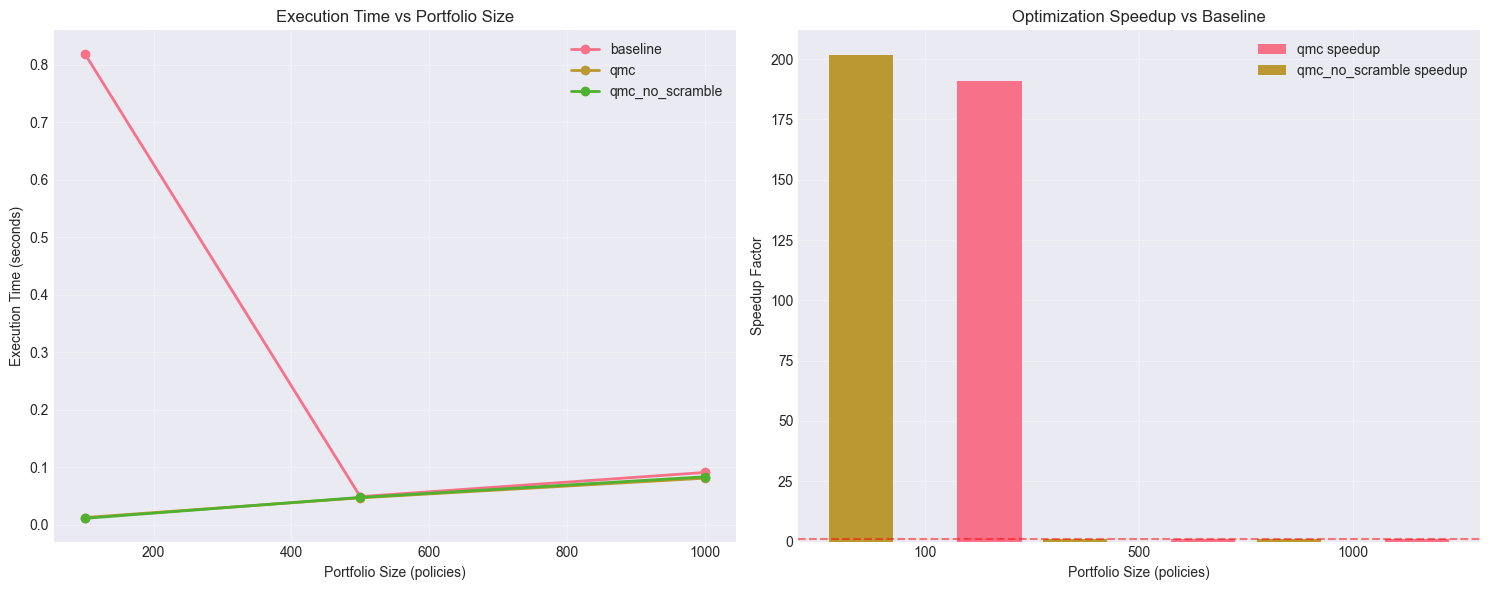

In [5]:
# Execution Time Comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Execution time by portfolio size
for opt in optimization_configs.keys():
    data = results_df[results_df['optimization'] == opt]
    avg_times = data.groupby('portfolio_size')['execution_time'].mean()
    axes[0].plot(avg_times.index, avg_times.values, marker='o', label=opt, linewidth=2)

axes[0].set_xlabel('Portfolio Size (policies)')
axes[0].set_ylabel('Execution Time (seconds)')
axes[0].set_title('Execution Time vs Portfolio Size')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Speedup ratios
baseline_times = results_df[results_df['optimization'] == 'baseline'].set_index(['portfolio_size', 'n_simulations'])['execution_time']
for opt in ['qmc', 'qmc_no_scramble']:
    opt_times = results_df[results_df['optimization'] == opt].set_index(['portfolio_size', 'n_simulations'])['execution_time']
    speedup = baseline_times / opt_times
    speedup_by_size = speedup.groupby(level=0).mean()
    axes[1].bar(np.arange(len(speedup_by_size)) + (0.3 if opt == 'qmc' else -0.3), 
                speedup_by_size.values, width=0.3, label=f'{opt} speedup')

axes[1].set_xlabel('Portfolio Size (policies)')
axes[1].set_ylabel('Speedup Factor')
axes[1].set_title('Optimization Speedup vs Baseline')
axes[1].set_xticks(range(len(portfolio_sizes)))
axes[1].set_xticklabels(portfolio_sizes)
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=1, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

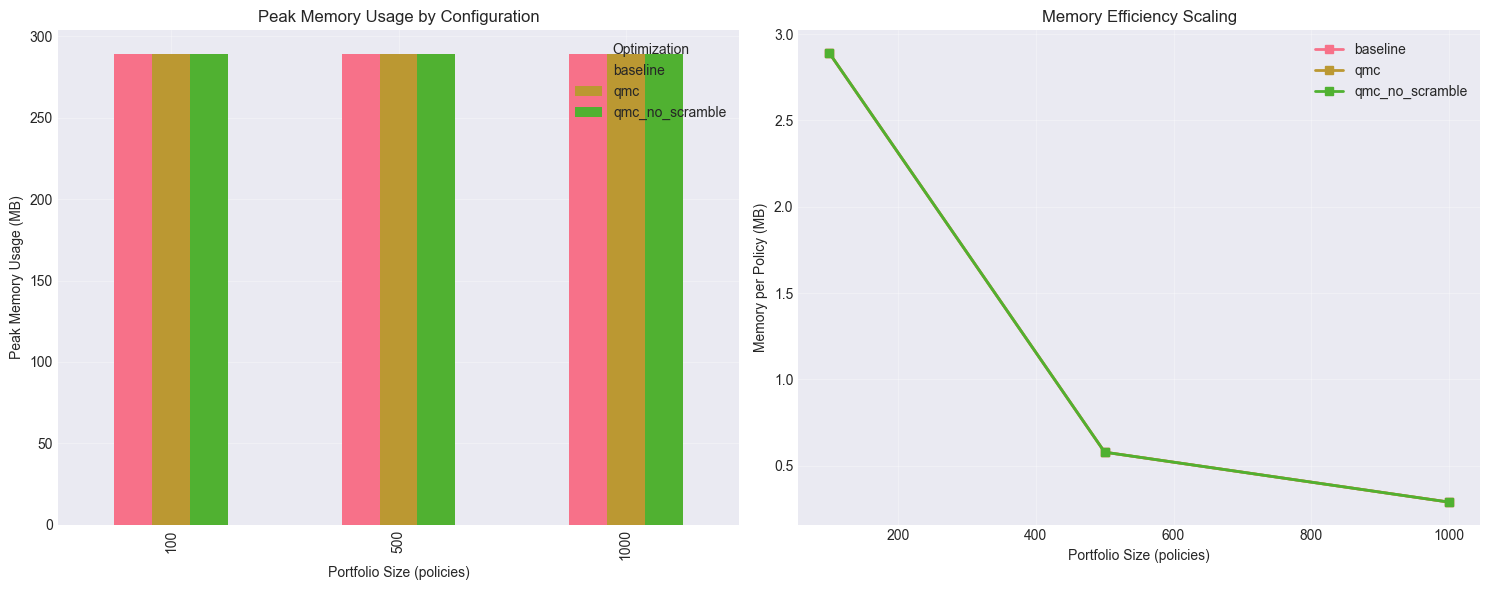

In [6]:
# Memory Usage Analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Peak memory by portfolio size
memory_pivot = results_df.pivot_table(
    values='peak_memory', 
    index='portfolio_size', 
    columns='optimization', 
    aggfunc='max'
)
memory_pivot.plot(kind='bar', ax=axes[0])
axes[0].set_xlabel('Portfolio Size (policies)')
axes[0].set_ylabel('Peak Memory Usage (MB)')
axes[0].set_title('Peak Memory Usage by Configuration')
axes[0].legend(title='Optimization')
axes[0].grid(True, alpha=0.3)

# Plot 2: Memory efficiency (memory per policy)
for opt in optimization_configs.keys():
    data = results_df[results_df['optimization'] == opt]
    memory_per_policy = data.groupby('portfolio_size').apply(
        lambda x: x['peak_memory'].max() / x['portfolio_size'].iloc[0]
    )
    axes[1].plot(memory_per_policy.index, memory_per_policy.values, 
                marker='s', label=opt, linewidth=2)

axes[1].set_xlabel('Portfolio Size (policies)')
axes[1].set_ylabel('Memory per Policy (MB)')
axes[1].set_title('Memory Efficiency Scaling')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Numerical Accuracy Validation

In [7]:
# Compare numerical accuracy across optimizations
accuracy_comparison = results_df.pivot_table(
    values=['mean_estimate', 'var_estimate'],
    index=['portfolio_size', 'n_simulations'],
    columns='optimization'
)

# Calculate relative differences from baseline
for metric in ['mean_estimate', 'var_estimate']:
    baseline_values = accuracy_comparison[(metric, 'baseline')]
    
    print(f"\nRelative Differences in {metric}:")
    for opt in ['qmc', 'qmc_no_scramble']:
        opt_values = accuracy_comparison[(metric, opt)]
        rel_diff = ((opt_values - baseline_values) / baseline_values * 100).abs()
        print(f"\n{opt} vs baseline:")
        print(f"  Mean relative difference: {rel_diff.mean():.3f}%")
        print(f"  Max relative difference: {rel_diff.max():.3f}%")


Relative Differences in mean_estimate:

qmc vs baseline:
  Mean relative difference: 0.385%
  Max relative difference: 0.908%

qmc_no_scramble vs baseline:
  Mean relative difference: 0.130%
  Max relative difference: 0.375%

Relative Differences in var_estimate:

qmc vs baseline:
  Mean relative difference: 0.476%
  Max relative difference: 0.950%

qmc_no_scramble vs baseline:
  Mean relative difference: 0.489%
  Max relative difference: 1.518%


## 6. Performance Trend Tracking

In [8]:
# Load historical baseline if available
historical_baseline = monitor.load_baseline()

if historical_baseline is not None:
    print("Comparing with historical baseline...")
    
    # Compare execution times
    current_avg = results_df.groupby(['portfolio_size', 'optimization'])['execution_time'].mean()
    historical_avg = historical_baseline.groupby(['portfolio_size', 'optimization'])['execution_time'].mean()
    
    performance_change = ((current_avg - historical_avg) / historical_avg * 100).round(2)
    
    print("\nPerformance change from baseline (%):") 
    print(performance_change)
    
    # Identify regressions
    regressions = performance_change[performance_change > 10]
    if len(regressions) > 0:
        print("\n⚠️ Performance Regressions Detected:")
        for idx, value in regressions.items():
            print(f"  {idx}: {value}% slower")
else:
    print("No historical baseline found. Saving current results as baseline...")
    monitor.save_baseline(results_df)

No historical baseline found. Saving current results as baseline...


## 7. Resource Utilization Patterns

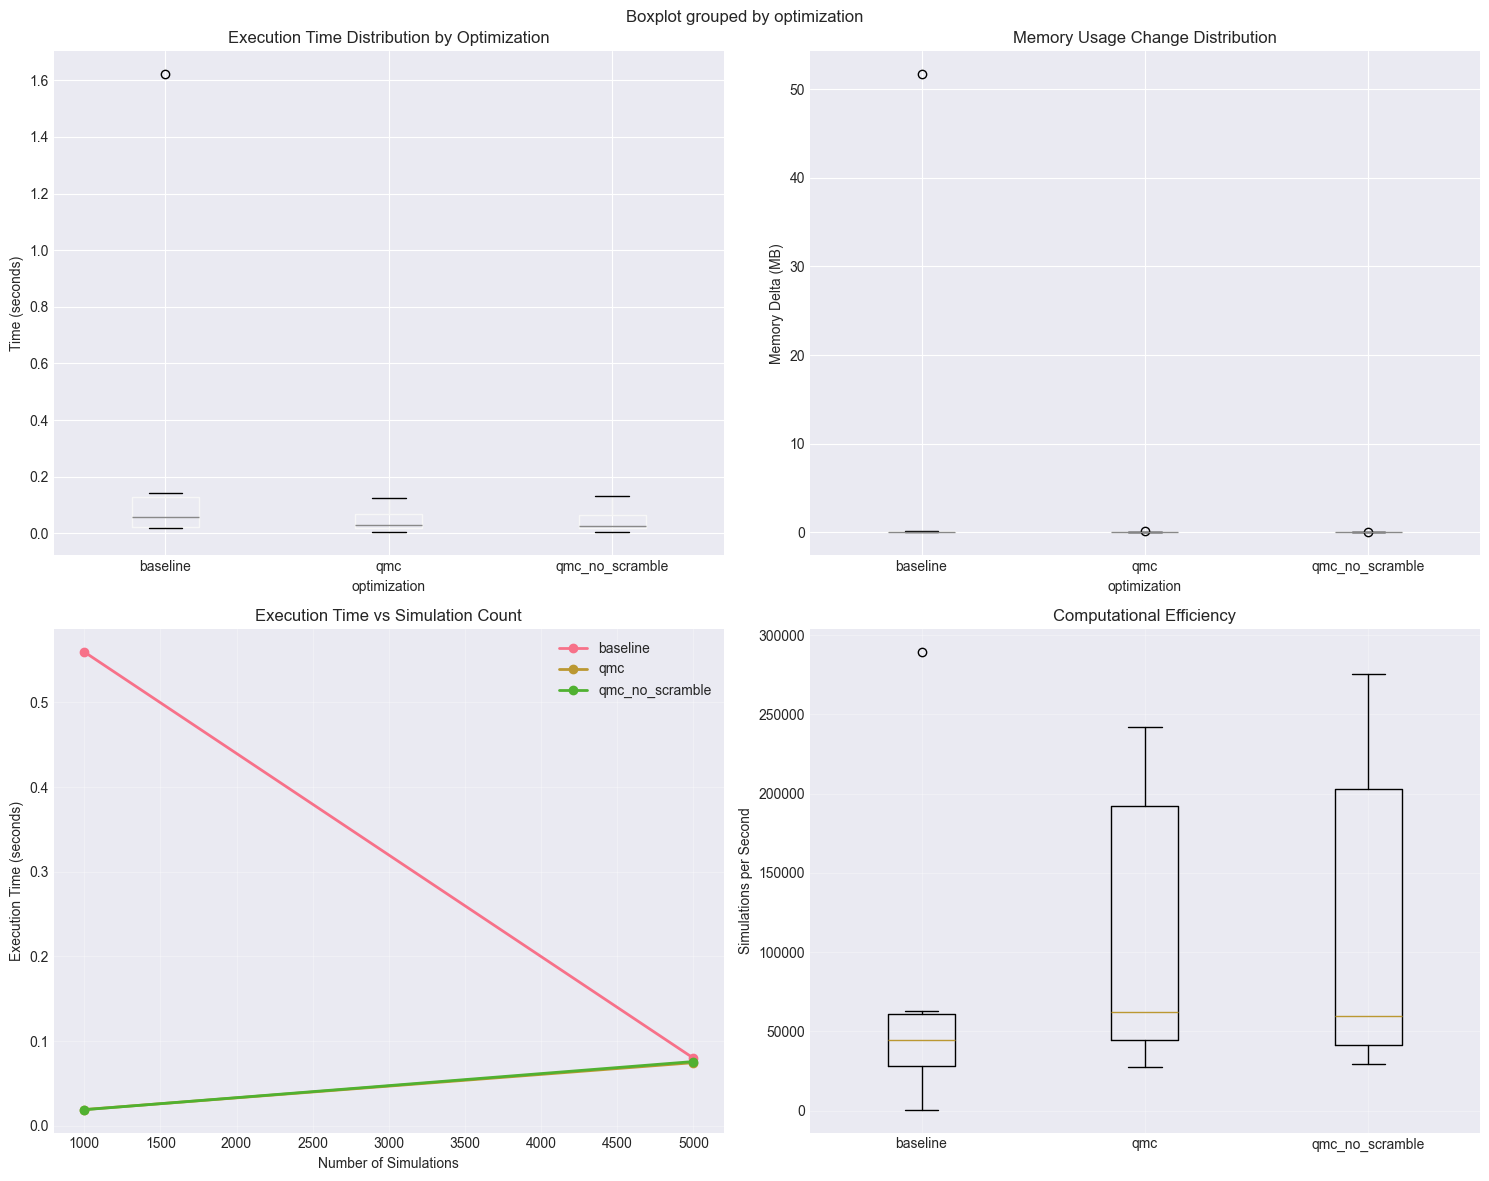

In [9]:
# Analyze resource utilization patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Execution time distribution
results_df.boxplot(column='execution_time', by='optimization', ax=axes[0, 0])
axes[0, 0].set_title('Execution Time Distribution by Optimization')
axes[0, 0].set_ylabel('Time (seconds)')

# Plot 2: Memory delta distribution  
results_df.boxplot(column='memory_delta', by='optimization', ax=axes[0, 1])
axes[0, 1].set_title('Memory Usage Change Distribution')
axes[0, 1].set_ylabel('Memory Delta (MB)')

# Plot 3: Scaling behavior
for opt in optimization_configs.keys():
    data = results_df[results_df['optimization'] == opt]
    scaling = data.groupby('n_simulations')['execution_time'].mean()
    axes[1, 0].plot(scaling.index, scaling.values, marker='o', label=opt, linewidth=2)

axes[1, 0].set_xlabel('Number of Simulations')
axes[1, 0].set_ylabel('Execution Time (seconds)')
axes[1, 0].set_title('Execution Time vs Simulation Count')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Efficiency metrics
efficiency_data = []
for opt in optimization_configs.keys():
    opt_data = results_df[results_df['optimization'] == opt]
    efficiency = opt_data['n_simulations'] / opt_data['execution_time']  # sims per second
    efficiency_data.append(efficiency.values)

axes[1, 1].boxplot(efficiency_data, labels=list(optimization_configs.keys()))
axes[1, 1].set_ylabel('Simulations per Second')
axes[1, 1].set_title('Computational Efficiency')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. System Recommendations

In [10]:
# Generate optimization recommendations based on results
print("=== Performance Optimization Recommendations ===")
print()

# Analyze speedup patterns
avg_speedup = {}
for opt in ['qmc', 'qmc_no_scramble']:
    baseline_times = results_df[results_df['optimization'] == 'baseline']['execution_time'].values
    opt_times = results_df[results_df['optimization'] == opt]['execution_time'].values
    avg_speedup[opt] = np.mean(baseline_times / opt_times)

# Memory efficiency
memory_efficiency = results_df.groupby('optimization')['peak_memory'].mean()
best_memory = memory_efficiency.idxmin()

# Recommendations
print("1. Performance Summary:")
for opt, speedup in avg_speedup.items():
    print(f"   - {opt}: {speedup:.2f}x average speedup")

print(f"\n2. Memory Efficiency:")
print(f"   - Most memory efficient: {best_memory}")
print(f"   - Average peak memory: {memory_efficiency[best_memory]:.1f} MB")

print("\n3. Recommendations by Portfolio Size:")
for size in portfolio_sizes:
    size_data = results_df[results_df['portfolio_size'] == size]
    best_opt = size_data.groupby('optimization')['execution_time'].mean().idxmin()
    print(f"   - {size} policies: Use {best_opt}")

print("\n4. General Guidelines:")
if avg_speedup.get('qmc', 0) > 1.5:
    print("   ✓ QMC provides significant speedup - recommended for large portfolios")
if avg_speedup.get('qmc_no_scramble', 0) > avg_speedup.get('qmc', 0):
    print("   ✓ Consider disabling scrambling for better performance")
else:
    print("   ✓ Owen scrambling improves accuracy with minimal performance impact")

# System resource warnings
max_memory = results_df['peak_memory'].max()
if max_memory > 4096:
    print(f"\n⚠️ Warning: Peak memory usage ({max_memory:.0f} MB) exceeds 4GB")
    print("   Consider batch processing for very large portfolios")

=== Performance Optimization Recommendations ===

1. Performance Summary:
   - qmc: 64.31x average speedup
   - qmc_no_scramble: 67.99x average speedup

2. Memory Efficiency:
   - Most memory efficient: baseline
   - Average peak memory: 289.2 MB

3. Recommendations by Portfolio Size:
   - 100 policies: Use qmc_no_scramble
   - 500 policies: Use qmc
   - 1000 policies: Use qmc

4. General Guidelines:
   ✓ QMC provides significant speedup - recommended for large portfolios
   ✓ Consider disabling scrambling for better performance


## 9. Export Performance Report

In [11]:
# Generate comprehensive performance report
report = {
    'timestamp': datetime.now().isoformat(),
    'summary': {
        'total_benchmarks': len(results_df),
        'portfolio_sizes': portfolio_sizes,
        'simulation_counts': n_simulations,
        'optimizations_tested': list(optimization_configs.keys())
    },
    'performance_metrics': {
        'average_speedup': avg_speedup,
        'memory_efficiency': memory_efficiency.to_dict(),
        'best_configuration': {
            'overall': results_df.groupby('optimization')['execution_time'].mean().idxmin(),
            'memory': best_memory
        }
    },
    'detailed_results': results_df.to_dict('records')
}

# Save report
report_filename = f"performance_report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
with open(report_filename, 'w') as f:
    json.dump(report, f, indent=2)

print(f"Performance report saved to: {report_filename}")

# Display summary statistics
print("\n=== Summary Statistics ===")
print(results_df.describe().round(2))

Performance report saved to: performance_report_20250526_085733.json

=== Summary Statistics ===
       portfolio_size  n_simulations  execution_time  memory_delta  \
count           18.00          18.00           18.00         18.00   
mean           533.33        3000.00            0.14          2.88   
std            378.85        2057.98            0.37         12.18   
min            100.00        1000.00            0.00          0.00   
25%            100.00        1000.00            0.02          0.00   
50%            500.00        3000.00            0.04          0.00   
75%           1000.00        5000.00            0.08          0.00   
max           1000.00        5000.00            1.62         51.69   

       peak_memory  mean_estimate  var_estimate  
count        18.00   1.800000e+01  1.800000e+01  
mean        289.18   2.053865e+08  2.329144e+08  
std           0.11   1.458619e+08  1.569941e+08  
min         288.98   3.834593e+07  5.152520e+07  
25%         289.14   3

## 10. Continuous Monitoring Setup

In [12]:
# Setup for continuous monitoring
print("=== Continuous Performance Monitoring Setup ===")
print()
print("To enable continuous monitoring:")
print("1. Schedule this notebook to run periodically (e.g., nightly)")
print("2. Set up alerts for performance regressions > 20%")
print("3. Track trends over time using the saved baselines")
print("4. Review optimization recommendations regularly")
print()
print("Current baseline saved for future comparisons.")
print(f"Next run will compare against: {monitor.baseline_file}")

=== Continuous Performance Monitoring Setup ===

To enable continuous monitoring:
1. Schedule this notebook to run periodically (e.g., nightly)
2. Set up alerts for performance regressions > 20%
3. Track trends over time using the saved baselines
4. Review optimization recommendations regularly

Current baseline saved for future comparisons.
Next run will compare against: performance_baseline.json
